In [1]:
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import interpolate as interp
import glob
from numpy.fft import ifft,fftshift, fft
import matplotlib.pyplot as plt
import os
import pickle


plt.rcParams['font.family'] = 'Times New Roman'

In [ ]:
def extract_static(target_idx):

    # 获取所有文件名
    h_file_list = glob.glob(f"F:\\cherium\\Desktop\\Dataset\\StaticData\\{target_idx}\\H_*.csv")
    v_file_list = glob.glob(f"F:\\cherium\\Desktop\\Dataset\\StaticData\\{target_idx}\\V_*.csv")

    # # 初始化频率和角度矩阵
    frequencies = np.arange(9e9, 11e9 + 0.01e9, 0.01e9)
    first_file = pd.read_csv(h_file_list[0])
    theta = first_file['Theta']  # 获取角度列的长度
    theta_len = theta.shape[0]

    # # 初始化f * theta的矩阵
    Ephi_H = np.zeros((len(frequencies), theta_len), dtype=complex)
    Etheta_H = np.zeros((len(frequencies), theta_len), dtype=complex)
    Etheta_V = np.zeros((len(frequencies), theta_len), dtype=complex)
    Ephi_V = np.zeros((len(frequencies), theta_len), dtype=complex)

    for idx, filename in enumerate(h_file_list):
        data = pd.read_csv(filename)
        Ephi_H[idx, :] = data["Re(Ephi)"].values + 1j * data["Im(Ephi)"].values
        Etheta_H[idx, :] = data["Re(Etheta)"].values + 1j * data["Im(Etheta)"].values


    for idx, filename in enumerate(v_file_list):
        data = pd.read_csv(filename)
        Ephi_V[idx, :] = data["Re(Ephi)"].values + 1j * data["Im(Ephi)"].values
        Etheta_V[idx, :] = data["Re(Etheta)"].values + 1j * data["Im(Etheta)"].values

    static_hrrp = {
        "HH": Ephi_H,
        "HV": Etheta_H,
        "VV": Etheta_V,
        "VH": Ephi_V,
    }
    return static_hrrp, theta, frequencies
    
def create_interpolation_functions(theta, static_hrrp):
    interpolation_functions_real = []
    interpolation_functions_imag = []
    
    for row in static_hrrp:
        real_part = row.real
        imag_part = row.imag
        
        interp_func_real = interp.interp1d(theta, real_part, kind='cubic')
        interp_func_imag = interp.interp1d(theta, imag_part, kind='cubic')
        
        interpolation_functions_real.append(interp_func_real)
        interpolation_functions_imag.append(interp_func_imag)
        
    return interpolation_functions_real, interpolation_functions_imag


def dynamic_hrrp(interpolation_functions_real, interpolation_functions_imag, angles):
    angles = np.array(angles)
    dynamic_hrrp_matrix = np.zeros((len(interpolation_functions_real), len(angles)), dtype=complex)
    
    for i, (interp_func_real, interp_func_imag) in enumerate(zip(interpolation_functions_real, interpolation_functions_imag)):
        real_part = interp_func_real(angles)
        imag_part = interp_func_imag(angles)
        
        dynamic_hrrp_matrix[i, :] = real_part + 1j * imag_part
    return dynamic_hrrp_matrix


def create_interpolation_dict(static_hrrp, theta):
    if static_hrrp is None:
        return None
    
    theta = theta.unique()

    interpolation_dict = {}
    for key, static_field in static_hrrp.items():
        interp_funcs_real, interp_funcs_imag = create_interpolation_functions(theta, static_field)
        interpolation_dict[key] = (interp_funcs_real, interp_funcs_imag)
    return interpolation_dict


def extract_hrrp(interpolation_dict, los_angles):
    if interpolation_dict is None:
        return None

    pol_hrrp = {}
    for key, (interp_funcs_real, interp_funcs_imag) in interpolation_dict.items():
        pol_hrrp[key] = dynamic_hrrp(interp_funcs_real, interp_funcs_imag, los_angles)
    return pol_hrrp

(50.0, 150.0)

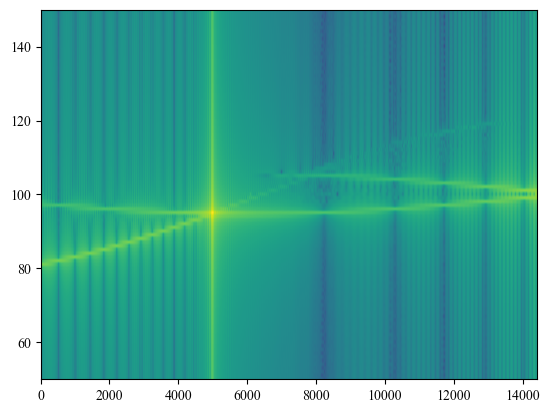

In [3]:
target_idx = 0

# 定义频率范围和步长
start_freq = 9e9  # 起始频率 9 GHz
end_freq = 11e9   # 结束频率 11 GHz
step = 0.01e9     # 步长 0.01 GHz

# 获取所有文件名
h_file_list = glob.glob(f"F:\\cherium\\Desktop\\Dataset\\StaticData\\{target_idx}\\H_*.csv")
v_file_list = glob.glob(f"F:\\cherium\\Desktop\\Dataset\\StaticData\\{target_idx}\\V_*.csv")

# # 初始化频率和角度矩阵
frequencies = np.arange(9e9, 11e9 + 0.01e9, 0.01e9)
first_file = pd.read_csv(h_file_list[0])
theta = first_file['Theta']  # 获取角度列的长度
theta_len = theta.shape[0]

# # 初始化f * theta的矩阵
Ephi_H = np.zeros((len(frequencies), theta_len), dtype=complex)
Etheta_H = np.zeros((len(frequencies), theta_len), dtype=complex)
Etheta_V = np.zeros((len(frequencies), theta_len), dtype=complex)
Ephi_V = np.zeros((len(frequencies), theta_len), dtype=complex)

for idx, filename in enumerate(h_file_list):
    data = pd.read_csv(filename)
    Ephi_H[idx, :] = data["Re(Ephi)"].values + 1j * data["Im(Ephi)"].values
    Etheta_H[idx, :] = data["Re(Etheta)"].values + 1j * data["Im(Etheta)"].values


for idx, filename in enumerate(v_file_list):
    data = pd.read_csv(filename)
    Ephi_V[idx, :] = data["Re(Ephi)"].values + 1j * data["Im(Ephi)"].values
    Etheta_V[idx, :] = data["Re(Etheta)"].values + 1j * data["Im(Etheta)"].values

static_hrrp = {
    "HH": Ephi_H,
    "HV": Etheta_H,
    "VV": Etheta_V,
    "VH": Ephi_V,
}

hrrp = fftshift(ifft(Ephi_H,axis = 0),axes=0)
hrrp = np.log10(np.abs(hrrp))

plt.imshow(hrrp, aspect='auto')
plt.ylim(50,150)

In [4]:
# 预处理数据

test_dir = './train/0/0.pkl'

with open(test_dir, 'rb') as file:
    instance = pickle.load(file)

target_idx = instance['target_id']


static_hrrp, theta, frequencies = extract_static(target_idx)
# # 使用tqdm监视循环进度

try:
    with open(test_dir, 'rb') as file:
        instance = pickle.load(file)
    if instance['hrrp'] is None:
        target_idx = instance['target_id']
        los_angles = instance['los']

        interpolation_dict = create_interpolation_dict(static_hrrp, theta)  
        hrrp_values = extract_hrrp(interpolation_dict, los_angles)
        
        instance['hrrp'] = hrrp_values

        with open(test_dir, 'wb') as file:
            pickle.dump(instance, file)


except Exception as e:
    print(f'error occured on {e} when dealing instance {test_dir}')

In [5]:
a = pickle.load(open('los_list_0.pkl', 'rb'))

target_idx = a[0]['Target_ID']

static_hrrp, theta, frequencies = extract_static(target_idx)
# # 使用tqdm监视循环进度

los_angles = a[0]['LOS']

interpolation_dict = create_interpolation_dict(static_hrrp, theta)  
hrrp_values = extract_hrrp(interpolation_dict, los_angles)

HRRP = hrrp_values


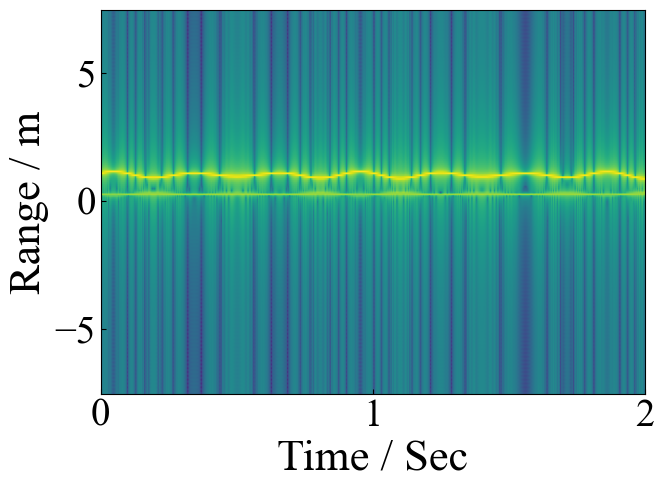

In [11]:
c = 3e8
f_c = 9e9
B = 2e9
dr = c / (2 * B)
x = np.arange(0, dr*201, dr) - dr*201/2

pol = 'VV'
hrrp = HRRP[pol]
hrrp = fftshift(ifft(hrrp,axis = 0),axes=0)
hrrp = np.log10(np.abs(hrrp))
o = hrrp[:,0]

plt.imshow(hrrp,extent=[0,2,x[0],x[-1]], aspect='auto')
# plt.ylim([-1,2])

# # 获取当前坐标轴
ax = plt.gca()

# # 设置y轴的位置
# ax.set_yticks([-50,0,50])
ax.set_xticks([0, 1, 2])

fontsize = 32

ax.set_xlabel('Time / Sec',fontsize=fontsize)
ax.set_ylabel('Range / m',fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=28)
# ax.get_yaxis().get_offset_text().set_size(25)  # Adjust the size as needed


plt.tick_params(direction='in')

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)

plt.savefig(f"./HRRP_{pol}.png", dpi=500, bbox_inches='tight')


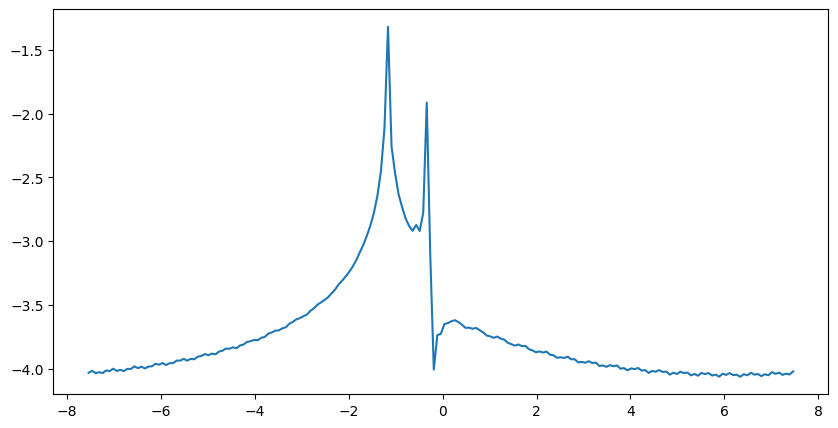

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(x, hrrp[:,0])

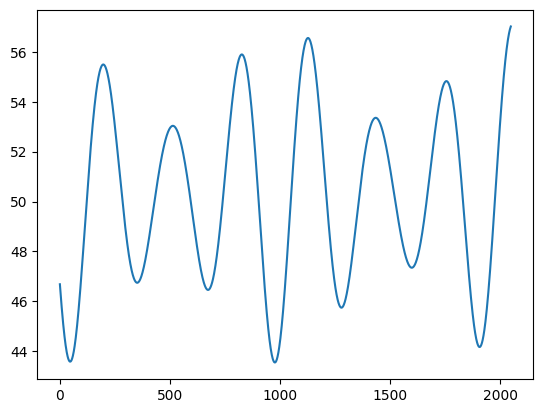

In [39]:
a = pickle.load(open('los_list_0.pkl', 'rb'))
plt.plot(a[0]['LOS'])

In [40]:
R = [np.linalg.norm(i) for i in a[0]['Radar_warhead']]

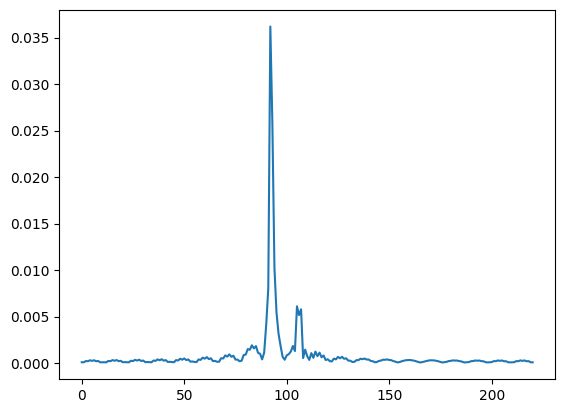

In [132]:
hrrp = instance['hrrp']['HH']
n = 10
hrrp = np.pad(hrrp[:,0], (n, n), 'constant')
plt.plot(np.abs(fftshift(ifft(hrrp))))

# R_ref = R[0]
# T_p = 0.1e-6
# PRF = 2048
# PRT = 1/PRF
# y = B/T_p
# dt = PRT/201

# Phi = np.exp(1j*np.pi*y*(T_p/2)**2)

# a = ifft(fft(hrrp[:,0])*Phi)

# # 定义已知变量（示例值，可根据实际情况修改）
# gamma = y  # 调频率 (Hz/s)
# Rp = R[0]  # 参考距离 (m)

# # 定义时间变量 t_n 和速度 v(t_n)
# t_n = np.linspace(0, T_p, 201+2*n)  # 100 个时间点，范围从 0 到 1 us
# v_tn = np.diff(R)[0] / dt  

# # 计算指数项
# Q = np.exp(1j * 2 * np.pi * (
#     gamma * (4 * Rp * v_tn / c**2)
#     - f_c * (2 * v_tn / c)
# ) * t_n - (gamma * (2 * v_tn / c) - gamma * (2 * v_tn / c) - gamma * (2 * v_tn**2 / c**2)) * t_n**2)

# a = a*Q

# b = np.log10(np.abs(fftshift(ifft(a,axis = 0),axes=0)))
# plt.plot(b)
# b.shape
# plt.plot(o)

In [133]:
def process_hrrp(instance, R, B, f_c, c=3e8, n=0, i = 0):
    """
    对高分辨距离像 (HRRP) 进行补零处理、匹配滤波和频谱计算。
    
    参数：
        instance : dict  -> 包含 HRRP 数据的字典（需含 'hrrp'->'HH' 键）。
        R : ndarray  -> 目标距离数组（单位：米）。
        B : float  -> 调频信号带宽（单位：Hz）。
        f_c : float -> 雷达载波频率（单位：Hz）。
        c : float  -> 光速（默认 3e8 m/s）。
        n : int  -> 补零长度（默认 0）。
    
    返回：
        b : ndarray  -> 处理后的 HRRP 频谱。
    """
    # 1. 读取 HRRP 数据，并进行补零
    hrrp = instance['hrrp']['HH']
    hrrp = np.pad(hrrp[:,i], (int(n), int(n)), mode='constant')

    # 2. 定义时间相关变量
    R_ref = R[i]  # 参考距离
    T_p = 0.1e-6  # 脉冲宽度
    PRF = 2048  # 脉冲重复频率
    PRT = 1 / PRF  # 脉冲重复周期
    y = B / T_p  # 线性调频率
    dt = PRT / 201  # 采样时间间隔

    # 3. 计算匹配滤波相位因子
    Phi = np.exp(1j * np.pi * y * (T_p / 2) ** 2)

    # 4. 匹配滤波：FFT * Phi
    a = ifft(fft(hrrp * Phi))

    # 5. 计算速度和时间变量
    gamma = y  # 调频率 (Hz/s)
    Rp = R_ref  # 参考距离
    t_n = np.linspace(0, T_p, 201 + 2*n)  # 时间向量
    v_r = np.diff(R) / dt
    v_r = np.append(v_r, v_r[-1]) # 计算目标速度
    v_tn = v_r[i]  # 计算目标速度

    # 6. 计算指数项 Q
    Q = np.exp(1j * 2 * np.pi * (
        gamma * (4 * Rp * v_tn / c**2)
        - f_c * (2 * v_tn / c)
    ) * t_n - (gamma * (2 * v_tn / c) - gamma * (2 * v_tn / c) - gamma * (2 * v_tn**2 / c**2)) * t_n**2)

    # 7. 进行匹配滤波后的相位补偿
    a = a * Q

    # 8. 计算 HRRP 频谱
    b = np.log10(np.abs(fftshift(ifft(a, axis=0), axes=0))+ 1e-10)

    return b

In [134]:
n = 10
hrrp_highspeed= np.zeros([201+2*n,512])
for i in range(0, 512):
    hrrp_highspeed[:, i] = process_hrrp(instance, R, B, f_c, n=10, i=i)
# process_hrrp(instance, R, B, f_c, c=3e8, n=0, i = 0)    

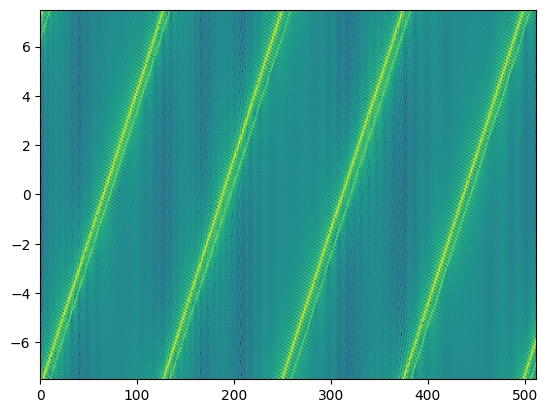

In [144]:
plt.imshow(hrrp_highspeed, extent=[0, 512, -7.5, 7.5], aspect='auto')
# plt.xlim(0, 200)

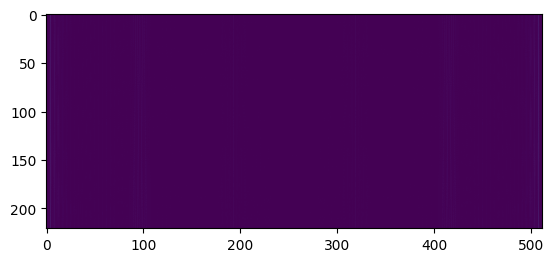

In [140]:
plt.imshow(np.abs(ifft(hrrp_highspeed)))

281.6

In [94]:
v = np.diff(R)/dt
v[0]*PRT

-1263.2505789273418

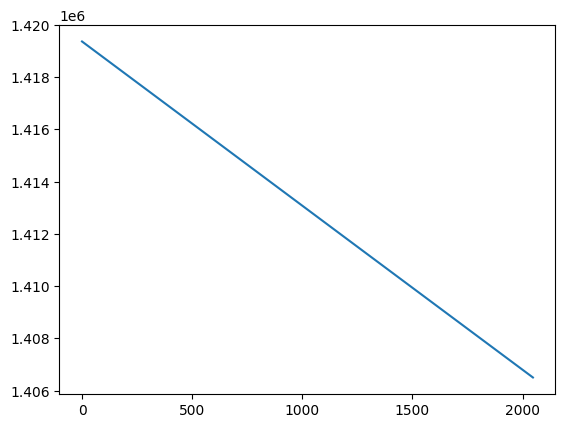

In [83]:
plt.plot(R)